In [1]:
import torch
import numpy as np
from cmb_ps import CMBPS, unnormalize_phi, normalize_phi
from hmc import HMC
import matplotlib.pyplot as plt

In [2]:
device = 0

In [3]:
def sample_prior(n):
    """
    Sample from the (normalized) prior distribution.
    phi = (H0, Obh2) with H0 ~ U(0, 1), Obh2 ~ U(0, 1)
    (unnormalized prior is H0 ~ U(50, 90), Obh2 ~ U(0.0075, 0.0567))
    """
    phi = torch.rand(n, 2).to(device)
    return phi

ps_model = CMBPS(norm_phi=True).to(device)

In [4]:
phi = sample_prior(10)
ps = ps_model(phi)
print("Input shape:", phi.shape)
print("Output shape:", ps.shape)

Input shape: torch.Size([10, 2])
Output shape: torch.Size([10, 256, 256])


In [5]:
phi_test = normalize_phi(torch.tensor([70, 32.1e-3]).to(device))
print("Normalized test phi:", phi_test)
ps_test = ps_model(phi_test)
x_test = torch.fft.ifft2(torch.fft.fft2(torch.randn((256, 256), device=device))*torch.sqrt(ps_test)).real

Normalized test phi: tensor([0.5000, 0.5000], device='cuda:0')


In [6]:
def log_likelihood(phi, x):
    """
    Compute the log likelihood of the Gaussian model.
    """
    x_dim = x.shape[-1]*x.shape[-2]

    ps = ps_model(phi)
    xf = torch.fft.fft2(x)

    term_pi = -(x_dim/2) * np.log(2*np.pi)
    term_logdet = -1/2*torch.sum(torch.log(ps), dim=(-1, -2)) # The determinant is the product of the diagonal elements of the PS
    term_x = -1/2*torch.sum(1/ps*torch.abs(xf)**2, dim=(-1, -2))/x_dim # We divide by x_dim because of the normalization of the FFT

    return term_pi + term_logdet + term_x

def log_prior(phi):
    """
    Compute the log (normalized) prior of the parameters.
    """
    H0, Obh2 = phi[..., 0], phi[..., 1]
    term_H0 = torch.log(torch.logical_and(H0 >= 0.0, H0 <= 1.0).float())
    term_Obh2 = torch.log(torch.logical_and(Obh2 >= 0.0, Obh2 <= 1.0).float())
    return term_H0 + term_Obh2

def log_posterior(phi, x):
    """
    Compute the log posterior of the parameters (not normalized by the evidence).
    """
    return log_likelihood(phi, x) + log_prior(phi)

In [7]:
log_prob = lambda phi: log_posterior(torch.tensor(phi).float().to(device), x_test).cpu().numpy()
def log_prob_grad(phi):
    """
    Compute the log posterior and its gradient.
    """
    phi = torch.tensor(phi).float().to(device).detach().requires_grad_()
    log_prob = log_posterior(phi, x_test)
    grad_log_prob = torch.autograd.grad(log_prob, phi, grad_outputs=torch.ones_like(log_prob))[0]
    return log_prob.detach().cpu().numpy(), grad_log_prob.cpu().numpy()

In [8]:
hmc = HMC(log_prob, log_prob_and_grad=log_prob_grad)

kwargs = {'nsamples': 10,
          'burnin': 10,
          'step_size': 0.01,
          'nleap': 10}

nchains = 10
samples_list = []
for i in range(nchains):
    print("Chain", i)
    phi_0 = sample_prior(1)[0].cpu().numpy()
    sampler = hmc.sample(phi_0, **kwargs)
    samples_list.append(sampler.samples)

Chain 0
Chain 1
Chain 2
Chain 3
Chain 4
Chain 5
Chain 6


/mnt/home/bregaldosaintblancard/Projects/Diffusion4Dust/cmb_hmc/hmc.py:182: RuntimeWarning: overflow encountered in exp
  prob = np.exp(H0 - H1)


Chain 7
Chain 8
Chain 9


In [13]:
samples_list[i][:, 1]

array([0.51342654, 0.49228126, 0.52852649, 0.47917312, 0.50392078,
       0.47247768, 0.49663642, 0.51257017, 0.49148765])

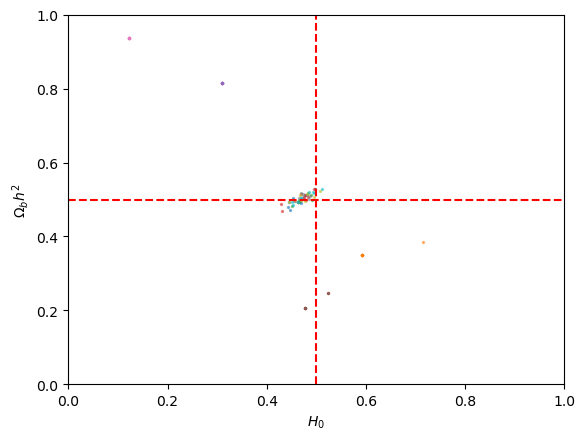

In [21]:
plt.figure()
for i in range(nchains):
    plt.scatter(samples_list[i][:, 0], samples_list[i][:, 1], s=2, alpha=0.5)
plt.axvline(phi_test[0].cpu().numpy(), color='red', linestyle='--')
plt.axhline(phi_test[1].cpu().numpy(), color='red', linestyle='--')
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_b h^2$")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()